In [ ]:
# ======================
# Step 2: Unzip dataset if not already done
# ======================
# Step 1: Paths on Kaggle
# ======================
import os, zipfile

# Kaggle automatically puts attached datasets in /kaggle/input/
data_path = "/kaggle/input/fer2013"
extract_path = "/kaggle/working/facial_recognition"  # /kaggle/working is writable

# ======================
# Step 2: Unzip dataset if not already done
# ======================
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted")
else:
    print("📂 Dataset already extracted")


In [7]:
# ======================
# Step 3: Imports
# ======================
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import numpy as np
from typing import Tuple

# ======================
# Step 4: Data transforms & dataset loading
# ======================
train_dir = os.path.join("/kaggle/input/fer2013", "train")

# We'll keep the strong augmentation you had, but produce 1-channel tensors.
# Complex net will internally expand to (real, imag).
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# ===== Load and split train set into train/val =====
full_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
num_classes = len(full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Use validation transforms for val_dataset
val_dataset.dataset.transform = transform_val

# ======================
# Step 4.5: Weighted sampler for imbalanced classes
# ======================
targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_sample_count = np.array([np.sum(np.array(targets) == t) for t in range(num_classes)])
weights = 1. / np.maximum(class_sample_count, 1)
samples_weights = np.array([weights[t] for t in targets], dtype=np.float32)
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

# ======================
# Step 5: DataLoaders
# ======================
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False,   num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================================
# Complex-valued building blocks (Real/Imag as separate tensors)
# ==========================================================
def _fan_in_fan_out(t: nn.Module):
    # Helper for Kaiming init style (conv/linear)
    if isinstance(t, nn.Conv2d):
        fan_in = t.in_channels * t.kernel_size[0] * t.kernel_size[1]
        fan_out = t.out_channels * t.kernel_size[0] * t.kernel_size[1]
        return fan_in, fan_out
    if isinstance(t, nn.Linear):
        return t.in_features, t.out_features
    return None, None

class ComplexConv2d(nn.Module):
    """
    y = (Wr * xr - Wi * xi) + j(Wr * xi + Wi * xr)
    Implemented with two Conv2d modules: Wr and Wi.
    """
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.real = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=bias)
        self.imag = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        for conv in [self.real, self.imag]:
            nn.init.kaiming_uniform_(conv.weight, a=np.sqrt(5))
            if conv.bias is not None:
                fan_in, _ = _fan_in_fan_out(conv)
                bound = 1 / np.sqrt(fan_in) if fan_in else 0.01
                nn.init.uniform_(conv.bias, -bound, bound)

    def forward(self, xr, xi):
        yr = self.real(xr) - self.imag(xi)
        yi = self.real(xi) + self.imag(xr)
        return yr, yi

class ComplexLinear(nn.Module):
    """
    y = (Wr * xr - Wi * xi) + j(Wr * xi + Wi * xr)
    """
    def __init__(self, in_f, out_f, bias=True):
        super().__init__()
        self.real = nn.Linear(in_f, out_f, bias=bias)
        self.imag = nn.Linear(in_f, out_f, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        for lin in [self.real, self.imag]:
            nn.init.kaiming_uniform_(lin.weight, a=np.sqrt(5))
            if lin.bias is not None:
                fan_in, _ = _fan_in_fan_out(lin)
                bound = 1 / np.sqrt(fan_in) if fan_in else 0.01
                nn.init.uniform_(lin.bias, -bound, bound)

    def forward(self, xr, xi):
        yr = self.real(xr) - self.imag(xi)
        yi = self.real(xi) + self.imag(xr)
        return yr, yi

class ComplexBatchNorm2d(nn.Module):
    """
    Simple variant: apply BN to real and imag independently (shared affine optional).
    This is not the full complex BN with 2x2 covariance, but works well in practice.
    """
    def __init__(self, num_features, affine=True, eps=1e-5, momentum=0.1):
        super().__init__()
        self.bn_r = nn.BatchNorm2d(num_features, affine=affine, eps=eps, momentum=momentum)
        self.bn_i = nn.BatchNorm2d(num_features, affine=affine, eps=eps, momentum=momentum)

    def forward(self, xr, xi):
        return self.bn_r(xr), self.bn_i(xi)

class ComplexDropout2d(nn.Module):
    """
    Apply the same dropout mask to real and imag.
    """
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, xr, xi):
        if not self.training or self.p == 0.0:
            return xr, xi
        mask = (torch.rand_like(xr) > self.p).float() / (1.0 - self.p)
        return xr * mask, xi * mask

class ModReLU(nn.Module):
    """
    modReLU: y = ReLU(|z| + b) * z / (|z| + eps)
    b is learnable per-channel bias (broadcast over spatial dims).
    """
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.b = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.eps = eps

    def forward(self, xr, xi):
        mag = torch.sqrt(xr**2 + xi**2 + self.eps)
        # ReLU(|z| + b)
        act = torch.relu(mag + self.b)
        scale = act / (mag + self.eps)
        return xr * scale, xi * scale

class ComplexAvgPool2d(nn.Module):
    """
    Pool on magnitude to pick the averaging scale, preserve phase.
    A simple and stable option: avg-pool real and imag independently.
    """
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)

    def forward(self, xr, xi):
        return self.pool(xr), self.pool(xi)

def complex_cat(chunks: Tuple[torch.Tensor, torch.Tensor], dim=1):
    xr, xi = chunks
    return xr, xi

def complex_to_magnitude(xr, xi, eps=1e-8):
    return torch.sqrt(xr**2 + xi**2 + eps)

# ==========================================================
# Complex CNN backbone for FER
# ==========================================================
def sobel_edges(x: torch.Tensor) -> torch.Tensor:
    """Compute edge map using Sobel filter. Input: (B,1,H,W). Output: (B,1,H,W)."""
    sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32, device=x.device).view(1,1,3,3)
    sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32, device=x.device).view(1,1,3,3)

    gx = F.conv2d(x, sobel_x, padding=1)
    gy = F.conv2d(x, sobel_y, padding=1)
    g = torch.sqrt(gx**2 + gy**2 + 1e-6)   # gradient magnitude
    return g
    
class ComplexFERNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Input: (B, 1, 224, 224) -> we internally create (real=img, imag=zeros)
        self.block1 = nn.ModuleDict(dict(
            conv = ComplexConv2d(1, 32, kernel_size=5, stride=1, padding=2),
            bn   = ComplexBatchNorm2d(32),
            act  = ModReLU(32),
            pool = ComplexAvgPool2d(2)  # 112x112
        ))
        self.block2 = nn.ModuleDict(dict(
            conv = ComplexConv2d(32, 64, kernel_size=3, stride=1, padding=1),
            bn   = ComplexBatchNorm2d(64),
            act  = ModReLU(64),
            pool = ComplexAvgPool2d(2)  # 56x56
        ))
        self.block3 = nn.ModuleDict(dict(
            conv = ComplexConv2d(64, 128, kernel_size=3, stride=1, padding=1),
            bn   = ComplexBatchNorm2d(128),
            act  = ModReLU(128),
            pool = ComplexAvgPool2d(2)  # 28x28
        ))
        self.block4 = nn.ModuleDict(dict(
            conv = ComplexConv2d(128, 256, kernel_size=3, stride=1, padding=1),
            bn   = ComplexBatchNorm2d(256),
            act  = ModReLU(256),
            pool = ComplexAvgPool2d(2)  # 14x14
        ))
        self.dropout = ComplexDropout2d(0.2)

        # Flatten size: 256 * 14 * 14
        self.flat_dim = 256 * 14 * 14
        #self.fc1 = ComplexLinear(self.flat_dim, 512)
        self.fc1 = nn.Linear(self.flat_dim, 512)
        self.fc1_act = nn.ReLU(inplace=True)  # real-valued after magnitude
        self.out = nn.Linear(512, num_classes)

    def forward(self, x):  # x: (B, 1, H, W)
        xr = x
        xi = sobel_edges(x)

        # Block 1
        xr, xi = self.block1['conv'](xr, xi)
        xr, xi = self.block1['bn'](xr, xi)
        xr, xi = self.block1['act'](xr, xi)
        xr, xi = self.block1['pool'](xr, xi)

        # Block 2
        xr, xi = self.block2['conv'](xr, xi)
        xr, xi = self.block2['bn'](xr, xi)
        xr, xi = self.block2['act'](xr, xi)
        xr, xi = self.block2['pool'](xr, xi)

        # Block 3
        xr, xi = self.block3['conv'](xr, xi)
        xr, xi = self.block3['bn'](xr, xi)
        xr, xi = self.block3['act'](xr, xi)
        xr, xi = self.block3['pool'](xr, xi)

        # Block 4
        xr, xi = self.block4['conv'](xr, xi)
        xr, xi = self.block4['bn'](xr, xi)
        xr, xi = self.block4['act'](xr, xi)
        xr, xi = self.block4['pool'](xr, xi)

        xr, xi = self.dropout(xr, xi)

        # Convert to magnitude for real-valued head
        mag = complex_to_magnitude(xr, xi)  # (B, C, H, W)
        mag = torch.flatten(mag, 1)         # (B, flat_dim)

        # Real-valued classifier head
        z = self.fc1(mag)[0] if isinstance(self.fc1(mag), tuple) else self.fc1(mag)
        z = self.fc1_act(z)
        logits = self.out(z)  # (B, num_classes)
        
        return logits


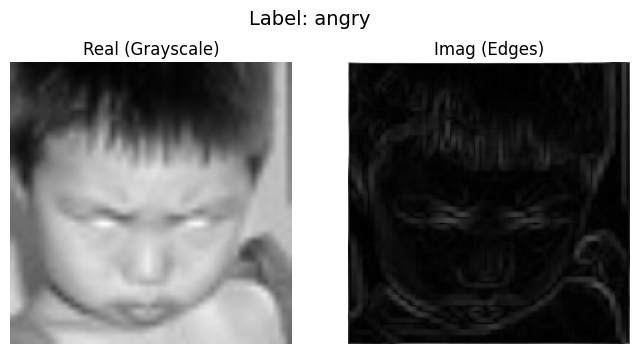

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Take one sample from dataset
img_tensor, label = full_dataset[0]  # (C,H,W), label

# Make sure it's a single-channel tensor
img_tensor = img_tensor[0:1, :, :].unsqueeze(0)  # (1,1,H,W) for batch dimension

# Compute imaginary channel (Sobel edges)
def sobel_edges(x: torch.Tensor) -> torch.Tensor:
    sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32).view(1,1,3,3)
    sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32).view(1,1,3,3)
    sobel_x = sobel_x.to(x.device)
    sobel_y = sobel_y.to(x.device)
    gx = F.conv2d(x, sobel_x, padding=1)
    gy = F.conv2d(x, sobel_y, padding=1)
    g = torch.sqrt(gx**2 + gy**2 + 1e-6)
    return g

xr = img_tensor
xi = sobel_edges(img_tensor)

# Convert tensors to numpy
real_img = xr.squeeze().numpy()
imag_img = xi.squeeze().numpy()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(real_img, cmap="gray")
axs[0].set_title("Real (Grayscale)")
axs[0].axis("off")

axs[1].imshow(imag_img, cmap="gray")
axs[1].set_title("Imag (Edges)")
axs[1].axis("off")

plt.suptitle(f"Label: {full_dataset.classes[label]}", fontsize=14)
plt.show()


In [9]:
# ======================
# Instantiate model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexFERNet(num_classes=num_classes)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
model = model.to(device)

# ======================
# Loss & Optimizer
# ======================
# Class weights against imbalance (same idea as your ViT script)
class_weights = torch.tensor(class_sample_count.sum() / np.maximum(class_sample_count, 1), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ======================
# Training Loop
# ======================
epochs = 15
best_val_acc = 0.0

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(imgs)  # logits
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    scheduler.step()

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / max(val_total, 1)
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Val Loss: {val_loss/len(val_loader):.4f} "
          f"Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "complex_fer_best.pth")
        print("💾 Saved best model!")

print("✅ Training complete")

Using 2 GPUs


/tmp/ipykernel_36/3313597265.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipykernel_36/3313597265.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch [1/15] Train Loss: 1.5822 Val Loss: 1.8548 Val Acc: 23.69%
💾 Saved best model!
Epoch [2/15] Train Loss: 0.7273 Val Loss: 1.6941 Val Acc: 31.26%
💾 Saved best model!
Epoch [3/15] Train Loss: 0.6017 Val Loss: 1.6943 Val Acc: 35.41%
💾 Saved best model!
Epoch [4/15] Train Loss: 0.5279 Val Loss: 1.6301 Val Acc: 38.42%
💾 Saved best model!
Epoch [5/15] Train Loss: 0.4797 Val Loss: 1.7367 Val Acc: 41.27%
💾 Saved best model!
Epoch [6/15] Train Loss: 0.4493 Val Loss: 1.6127 Val Acc: 44.93%
💾 Saved best model!
Epoch [7/15] Train Loss: 0.4097 Val Loss: 1.8006 Val Acc: 42.08%
Epoch [8/15] Train Loss: 0.3809 Val Loss: 1.8165 Val Acc: 49.27%
💾 Saved best model!
Epoch [9/15] Train Loss: 0.3641 Val Loss: 1.7565 Val Acc: 47.94%
Epoch [10/15] Train Loss: 0.3484 Val Loss: 1.7251 Val Acc: 48.28%
Epoch [11/15] Train Loss: 0.3359 Val Loss: 1.7361 Val Acc: 48.19%
Epoch [12/15] Train Loss: 0.3431 Val Loss: 1.7630 Val Acc: 47.42%
Epoch [13/15] Train Loss: 0.3357 Val Loss: 1.8034 Val Acc: 48.96%
Epoch [14/1

In [ ]:
# ======================
# Inference helper
# ======================
import torch.nn.functional as F
idx_to_class = {v:k for k, v in val_dataset.dataset.class_to_idx.items()}

def predict_image(img_tensor: torch.Tensor):
    """
    img_tensor: (1, H, W) normalized like validation transform
    """
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(device)
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1)[0]
        top_p, top_i = probs.topk(3)
        return [(idx_to_class[i.item()], p.item()) for i, p in zip(top_i, top_p)]

In [11]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import torch

# ======================
# Test dataset
# ======================
test_dir = "/kaggle/input/fer2013/test"

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# ======================
# Load best model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexFERNet(num_classes=len(test_dataset.classes))
checkpoint_path = "complex_fer_best.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# If saved with DataParallel, remove 'module.' prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove `module.` prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.to(device)
model.eval()


# ======================
# Evaluation
# ======================
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Classification report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

       angry       0.42      0.39      0.40       958
     disgust       0.52      0.41      0.46       111
        fear       0.47      0.18      0.26      1024
       happy       0.71      0.66      0.69      1774
     neutral       0.40      0.60      0.48      1233
         sad       0.36      0.45      0.40      1247
    surprise       0.69      0.63      0.66       831

    accuracy                           0.50      7178
   macro avg       0.51      0.47      0.48      7178
weighted avg       0.52      0.50      0.50      7178

Confusion Matrix:
 [[ 372   13   49   94  200  200   30]
 [  20   46    2    7   15   18    3]
 [ 129    4  185   90  220  282  114]
 [  82    6   28 1176  225  208   49]
 [  97    4   26  114  741  236   15]
 [ 142   12   55  123  331  556   28]
 [  38    4   47   53  100   64  525]]
